In [160]:
#0 - Import Dependencies
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

C:\Users\User\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (5,9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
#1 - Import UFO Sightings data
ufo_sightings = pd.read_csv("../Resources/scrubbed_csv.csv")

In [ ]:
#2 - Clean UFO Sightings data
ufo_clean = ufo_sightings.loc[ufo_sightings["country"]=="us"]
ufo_clean[['month', 'day', 'year']] = ufo_clean['datetime'].str.split('/',expand=True)
ufo_clean[['year', 'time']] = ufo_clean['year'].str.split(' ',expand=True)
ufo_clean=ufo_clean.dropna()
ufo_clean['duration (seconds)']=pd.to_numeric(ufo_clean['duration (seconds)'])
ufo_clean['latitude']=pd.to_numeric(ufo_clean['latitude'])
ufo_clean['longitude']=pd.to_numeric(ufo_clean['longitude ']) #note: 'longitude ' has a space at the end
ufo_clean['month']=pd.to_numeric(ufo_clean['month'])
ufo_clean['day']=pd.to_numeric(ufo_clean['day'])
ufo_clean['year']=pd.to_numeric(ufo_clean['year'])
#ufo_clean.dtypes

In [161]:
#3 - Convert UFO Sightings to Geopandas Geodataframe
gdf_sightings = GeoDataFrame( 
    ufo_clean.drop(['longitude ','latitude'],axis=1),
    crs={'init':'epsg:4326'}, #WGS84 coordinate system
    geometry=[Point(xy) for xy in zip(ufo_clean.longitude ,ufo_clean.latitude)])
#gdf_sightings.head()

In [162]:
#4 - Import Military Bases data
military = gpd.read_file("../Resources/military-bases.geojson")
#military.head()

In [163]:
#5 - Adds a buffer of 5 mile to UFO Sightings
ufo_buffer = gdf_sightings
#ufo_buffer = gdf_sightings.loc[gdf_sightings["year"]==2013]
#ufo_buffer = ufo_buffer.loc[ufo_buffer["month"]==7]
ufo_buffer.geometry = gdf_sightings.geometry.buffer(5*(1/60)) #Note: Rough conversion of degree to mile (1/60)
#ufo_buffer.head()

In [164]:
#6 - Spatial Join of UFO Sightings intersecting Military Bases using a buffer of 5 miles
ufo_join = gpd.sjoin(ufo_buffer,military,op="intersects")
#ufo_join

In [165]:
#7 - Create a group based on the values in the 'state' column and count how many times each state has UFO Sightings
overall_state_group = ufo_clean.groupby('state')
count_overall_state = overall_state_group['state'].count()
#count_overall_state
military_state_group = ufo_join.groupby('state')
count_military_state = military_state_group['state'].count()
#count_military_state

<IPython.core.display.Javascript object>


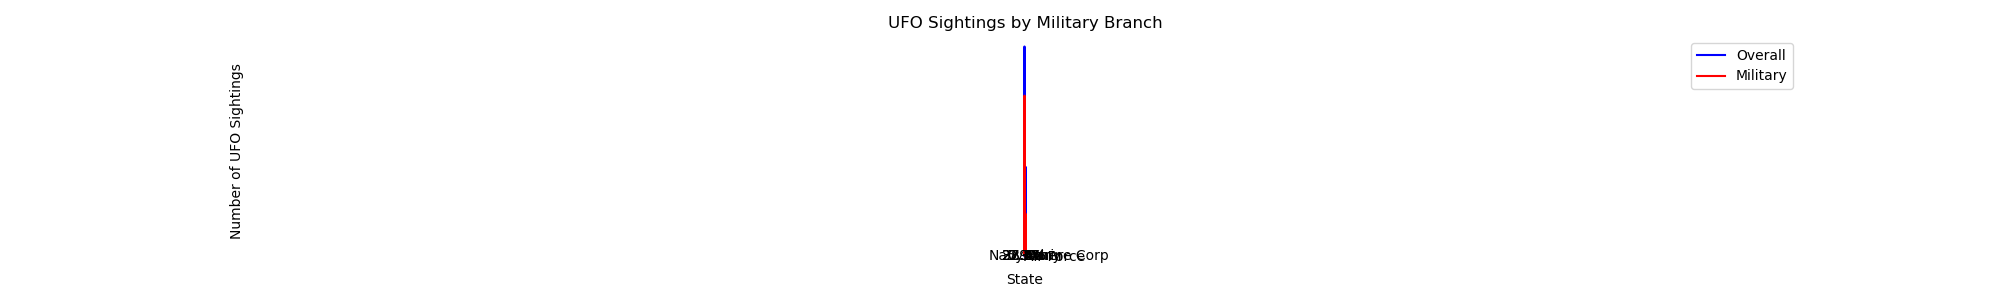

In [171]:
#8 - Create a bar chart based off of the 'site_name' group series
plt.figure(figsize=(20,3))
plt.title("UFO Sightings by State: Overall vs. Military")
plt.plot(count_overall_state,color='blue',label="Overall")
plt.plot(count_military_state,color='red',label="Military")
plt.xlabel("State")
plt.ylabel("Number of UFO Sightings")
plt.legend(loc="best")
plt.ylim(0,9000)
plt.grid()
plt.savefig("../Images/OverallvsMilitaryByState.png")
plt.show()

In [173]:
#9 - Create a group based on the values in the 'component' column and count how many times each military branch appears in our group
ufo_join = ufo_join.replace({"AF Active":"Air Force","AF Guard":"Air Force","AF Reserve":"Air Force","Army Active":"Army","Army Guard":"Army","Army Reserve":"Army","MC Active":"Marine Corp","MC Reserve":"Marine Corp","Navy Active":"Navy","WHS":"Other"})
branch_group = ufo_join.groupby('component')
count_branch = branch_group['component'].count()
count_branch = count_branch.reset_index(name='count')
count_branch = count_branch.sort_values(['count'],ascending=False)
count_branch = pd.DataFrame(count_branch)
#count_branch

<IPython.core.display.Javascript object>


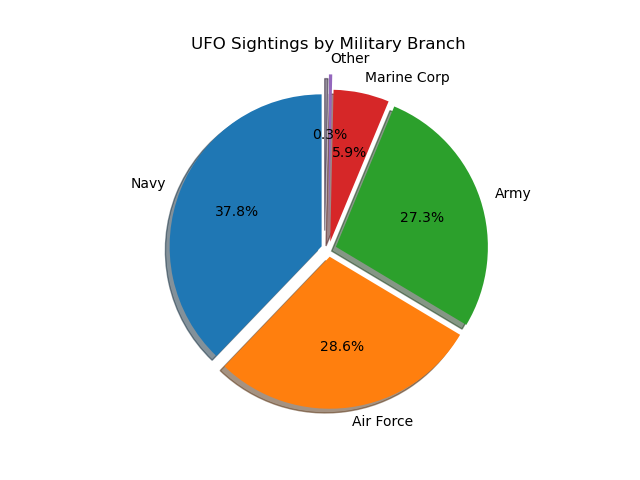

In [174]:
#10 - Create a pie chart based off the 'component' group series
data = count_branch["count"]
labels = count_branch["component"]
explode = (0.05,0.05,0.05,0.05,0.15)
plt.title("UFO Sightings by Military Branch")
plt.pie(data,explode=explode,labels=labels,autopct="%1.1f%%",shadow=True,startangle=90)
plt.axis("equal")
plt.savefig("../Images/Branches.png")
plt.show()

In [175]:
#11 - Create a group based on the values in the "year" column for both UFO Sightings and Military Bases
group_ufo_years = ufo_clean.groupby('year')
count_ufo_years = group_ufo_years['year'].count()
#count_ufo_years
group_military_years = ufo_join.groupby('year')
count_military_years = group_military_years['year'].count()
#count_military_years

<IPython.core.display.Javascript object>


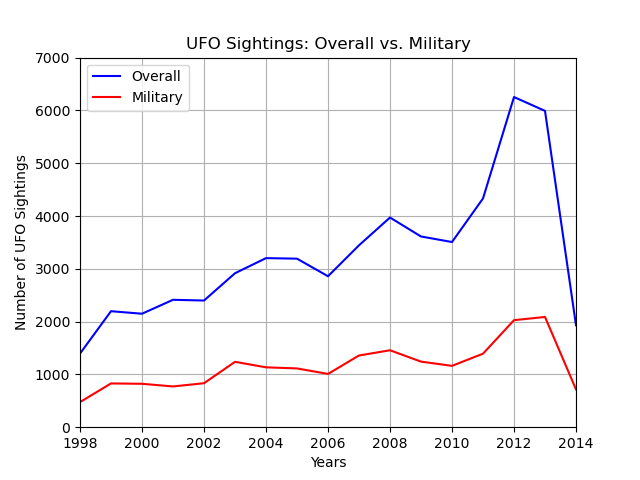

In [176]:
#12 - Create a line graph based off the 'year' group series for Total UFO Sightings vs. Military UFO Sightings
plt.title("UFO Sightings: Overall vs. Military")
plt.plot(count_ufo_years,color='blue',label="Overall")
plt.plot(count_military_years,color='red',label="Military")
plt.xlabel("Years")
plt.ylabel("Number of UFO Sightings")
plt.legend(loc="upper left")
plt.xlim(1998,2014)
plt.ylim(0,7000)
plt.grid()
plt.savefig("../Images/OverallvsMilitary.png")
plt.show()